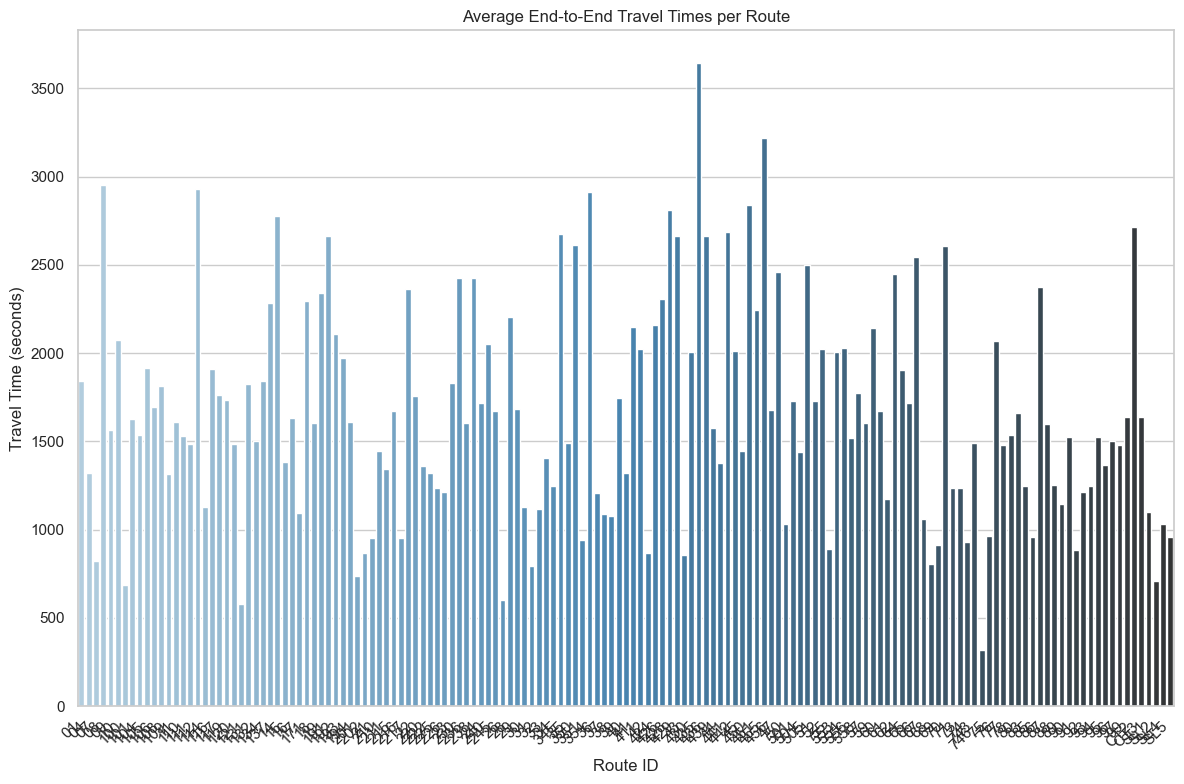

In [3]:
#visual graph of end to end service times for month of January 2022
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_end_to_end_time(filename):
    # Read the CSV file
    df = pd.read_csv(filename, parse_dates=['actual', 'scheduled'])

    # Filter rows for start and end points only
    df_filtered = df[df['point_type'].isin(['Startpoint', 'Endpoint'])]

    # Group by route_id, half_trip_id, and then apply a diff function on actual time
    df_filtered = df_filtered.sort_values(by=['route_id', 'half_trip_id', 'actual'])
    df_filtered['travel_time'] = df_filtered.groupby(['route_id', 'half_trip_id'])['actual'].diff()

    # Only keep the endpoint rows which now contain the travel time in the 'travel_time' column
    df_endpoints = df_filtered[df_filtered['point_type'] == 'Endpoint']

    # Calculate mean travel time for each route
    result = df_endpoints.groupby('route_id')['travel_time'].mean()

    # Convert travel time to total seconds for plotting
    result_seconds = result.dt.total_seconds()

    return result_seconds

def plot_travel_times(result_seconds):
    # Create a bar chart using seaborn
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 8))
    chart = sns.barplot(x=result_seconds.index, y=result_seconds.values, palette="Blues_d")

    # Set chart title and labels
    chart.set_title('Average End-to-End Travel Times per Route')
    chart.set_ylabel('Travel Time (seconds)')
    chart.set_xlabel('Route ID')
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

    # Save the chart as an image
    plt.tight_layout()
    plt.savefig('travel_times_chart.png')
    plt.show()

# Example
filename = 'MBTA/MBTA-Bus-Arrival-Departure-Times_2022-01.csv'
travel_times = calculate_end_to_end_time(filename)
plot_travel_times(travel_times)


In [8]:
#Calculates the end to end times in hours:minutes:seconds format and cleans all null values and stores them in coorsponding .csv files for each month

import pandas as pd

def calculate_end_to_end_time(filename):
    # Read the CSV file
    df = pd.read_csv(filename, parse_dates=['scheduled', 'actual'])

    # Filter rows where actual is not NaN
    df = df.dropna(subset=['actual'])

    # Calculate travel time for each trip
    df_grouped = df.groupby(['service_date', 'route_id', 'direction_id', 'half_trip_id'])

    # Finding the difference between the last and first actual time for each trip
    travel_time = df_grouped['actual'].max() - df_grouped['actual'].min()

    # Average travel time per route
    average_travel_time = travel_time.groupby('route_id').mean()

    return average_travel_time

def save_to_csv(result, month):
    # Convert the travel time to hours:minutes:seconds format and filter NaN values
    formatted_result = result.dt.total_seconds().dropna().apply(lambda x: f"{int(x // 3600)}:{int((x % 3600) // 60)}:{int(x % 60)}")
    formatted_result.to_csv(f'end_to_end_times_{month}.csv', header=['Average Travel Time'])

# Iterate through all months
for month in range(1, 13):
    filename = f'MBTA/MBTA-Bus-Arrival-Departure-Times_2022-{month:02}.csv'
    travel_times = calculate_end_to_end_time(filename)
    save_to_csv(travel_times, month)


In [15]:
#Calculates the lateness as a percentage and outputs to .csv file
import pandas as pd

def calculate_lateness(filename):
    # Read the CSV file
    df = pd.read_csv(filename, parse_dates=['scheduled', 'actual'])

    # Calculate if the bus is late
    df['late'] = (df['actual'] - df['scheduled']).dt.total_seconds() > 0

    # Group by route_id and calculate the percentage of times it's late
    route_lateness = df.groupby('route_id')['late'].mean() * 100

    return route_lateness

def save_to_csv(result):
    result.to_csv('average_route_lateness_percent_2022.csv', header=['Average Lateness Percentage'])

all_route_lateness = []

# Iterate through all months
for month in range(1,2):
    filename = f'MBTA/MBTA-Bus-Arrival-Departure-Times_2022-{month:02}.csv'
    lateness = calculate_lateness(filename)
    all_route_lateness.append(lateness)

# Combine all the monthly results and calculate the average for the year
average_lateness = pd.concat(all_route_lateness, axis=1).mean(axis=1)
save_to_csv(average_lateness)


In [9]:
#Calculates the lateness by seconds and outputs to .csv file (used for visual element)

import pandas as pd
import matplotlib.pyplot as plt

def calculate_lateness(filename):
    # Read the CSV file
    df = pd.read_csv(filename, parse_dates=['scheduled', 'actual'])
    
    # Calculate lateness for each trip
    df['lateness'] = (df['actual'] - df['scheduled']).dt.total_seconds()
    
    # Average lateness per route
    average_lateness = df.groupby('route_id')['lateness'].mean()
    
    return average_lateness

def save_lateness_to_csv(result):
    result.to_csv('average_route_lateness_seconds_2022.csv', header=['Average Lateness'])

# Calculate average lateness
all_lateness_data = []
for month in range(1, 13):
    filename = f'MBTA/MBTA-Bus-Arrival-Departure-Times_2022-{month:02}.csv'
    lateness = calculate_lateness(filename)
    all_lateness_data.append(lateness)

# Combine monthly data and compute overall average for the year
total_lateness = pd.concat(all_lateness_data, axis=1).mean(axis=1)
save_lateness_to_csv(total_lateness)


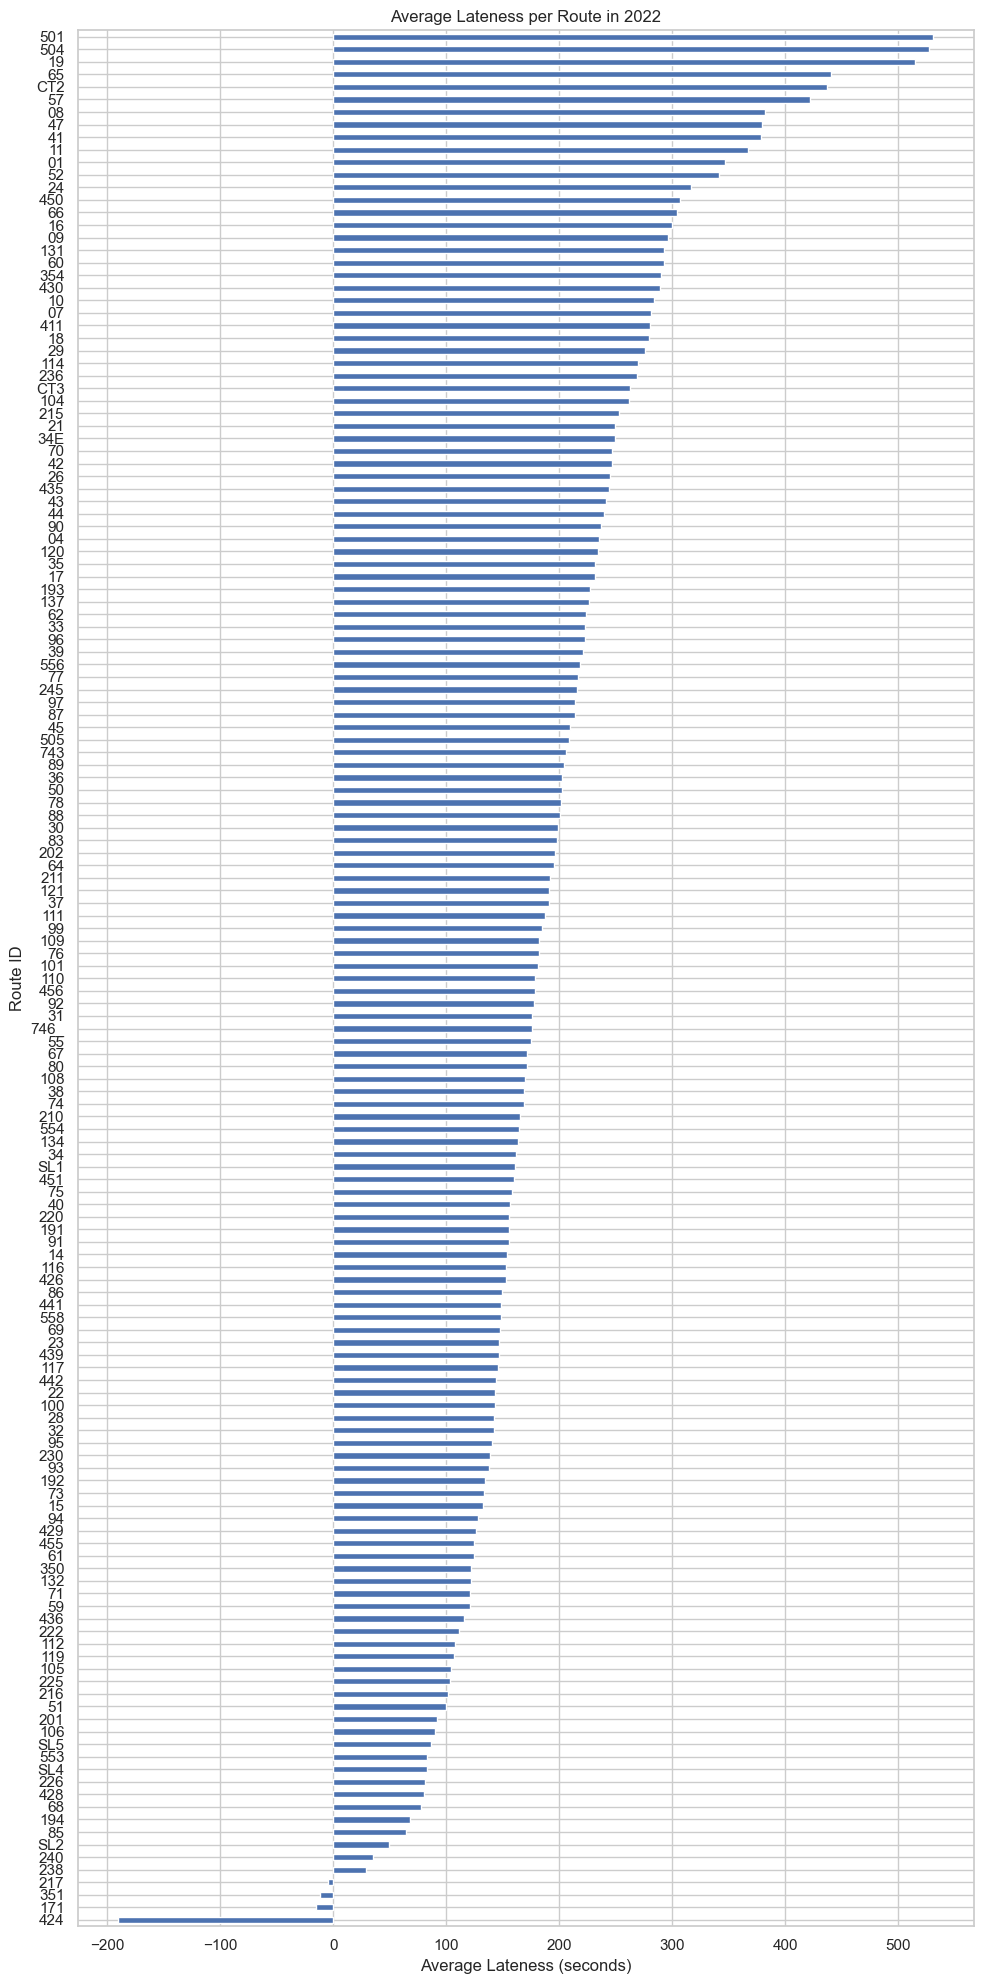

In [13]:
#Visual graph of average lateness for year of 2022 by bus route id's
def visualize_lateness():
    # Read the lateness data
    lateness_df = pd.read_csv('average_route_lateness_2022.csv', index_col='route_id')
    
    # Plot
    lateness_df.sort_values(by='Average Lateness', ascending=True).plot(kind='barh', figsize=(10, 20), legend=False)
    plt.title('Average Lateness per Route in 2022')
    plt.xlabel('Average Lateness (seconds)')
    plt.ylabel('Route ID')
    plt.tight_layout()
    plt.savefig('average_route_lateness_2022_plot.png')
    plt.show()

visualize_lateness()
